# 02 Huia Experience Training

## TODOS
- interpret layers visually
- tensorboard convergence
https://github.com/titu1994/keras-one-cycle
https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras 

# Setup 
## Install Tensorflow 2 Nightly and other Libraries

In [1]:
#tf addons only works with alpha for now
#!pip install tensorflow-gpu==2.0.0-alpha0  --force-reinstall

#!pip uninstall tensorflow-gpu==2.0.0-alpha0 
#!pip install tensorflow-estimator
#!pip install fastai
#!pip install tensorflow-addons
#!pip install opencv-python
#!pip install scipy
#!pip install sklearn
#nigthly packages (not currently working with addons)
#!pip install --upgrade --force-reinstall tf-nightly-gpu-2.0-preview

#!pip install tensorflow-estimator==2.0.0-alpha0  --upgrade --force-reinstall
#!pip uninstall -y tf-nightly-gpu-2.0-preview
#!pip uninstall -y tb-nightly==1.14.0a20190301
#!pip uninstall tensorflow-estimator==1.13.0
!pip freeze | egrep 'tensor|tb'

tb-nightly==1.14.0a20190301
tensorboardX==1.6
tensorflow-gpu==2.0.0a0


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import pathlib
import os
import random
import OneCycleLR

# enable logging to make sure we are running on the GPU
# tf.debugging.set_log_device_placement(True)

tf.__version__

'2.0.0-alpha0'

In [4]:

# clear any active session
tf.keras.backend.clear_session()

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

# Data
We have to understand well our data as this is fundamental to achieve good results.

In [5]:
root_path = pathlib.Path("./training_data/")
image_path = root_path /"images"
json_path = root_path /"json"
augmented_path = root_path/"augmented_imgs"

image_path,json_path ,augmented_path

(PosixPath('training_data/images'),
 PosixPath('training_data/json'),
 PosixPath('training_data/augmented_imgs'))

In [6]:
# lets set the random seed so we can reproduce our results
random.seed(7)

# get filenames from directories 
all_image_paths = list(image_path.glob('*.png')) + list(augmented_path.glob('*.png'))
#all_json_paths = list(json_path.glob('*.json'))

all_image_paths = [str(path) for path in all_image_paths] # convert to strings
random.shuffle(all_image_paths) # randomize

In [7]:
len(all_image_paths)#, len(all_json_paths)

4191

In [8]:
all_image_paths[:20] 

['training_data/augmented_imgs/moonwalk_86998.png',
 'training_data/augmented_imgs/normal_19994.png',
 'training_data/augmented_imgs/hadouken_518991.png',
 'training_data/augmented_imgs/backpack_1240991.png',
 'training_data/augmented_imgs/moonwalk_74990.png',
 'training_data/augmented_imgs/moonwalk_1230992.png',
 'training_data/augmented_imgs/underarm_872990.png',
 'training_data/augmented_imgs/underarm_247991.png',
 'training_data/augmented_imgs/normal_1203996.png',
 'training_data/images/fly_52.png',
 'training_data/augmented_imgs/fly_430991.png',
 'training_data/augmented_imgs/normal_2997.png',
 'training_data/augmented_imgs/normal_810994.png',
 'training_data/augmented_imgs/hadouken_1237999.png',
 'training_data/augmented_imgs/fly_48998.png',
 'training_data/augmented_imgs/hadouken_1238992.png',
 'training_data/augmented_imgs/backpack_1247992.png',
 'training_data/augmented_imgs/dramatic_940994.png',
 'training_data/augmented_imgs/moonwalk_74995.png',
 'training_data/augmented_img

In [9]:
import re
# extract categories for classification
pat = r'/([^/]+)_\d+.png$'
all_image_labels = [str(re.search(pat,str(image)).group(1)).lower() for image in all_image_paths]
len(all_image_labels)

4191

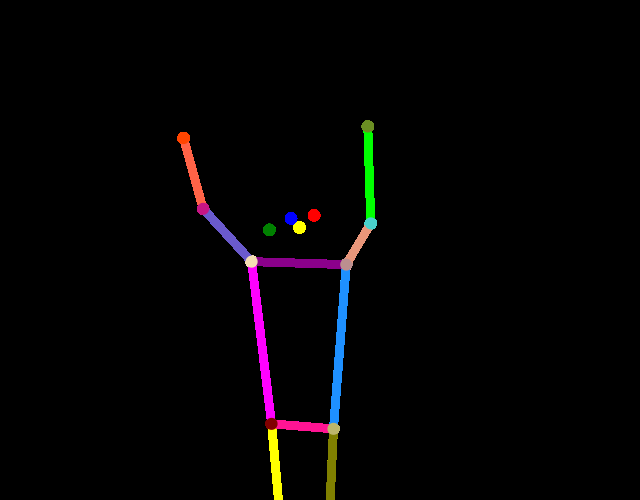

file: training_data/augmented_imgs/fly_858997.png


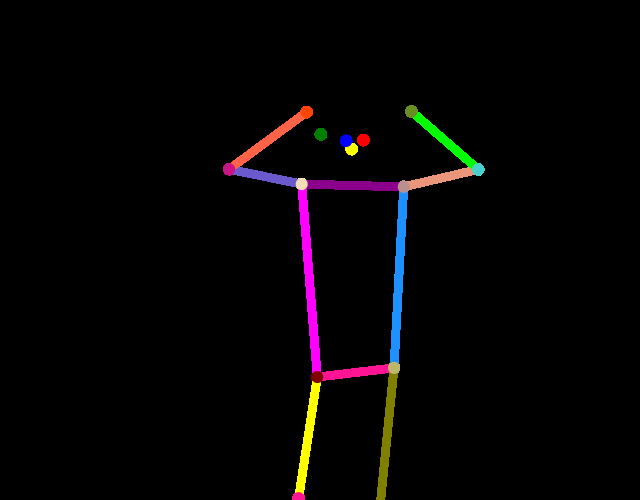

file: training_data/augmented_imgs/dramatic_126996.png


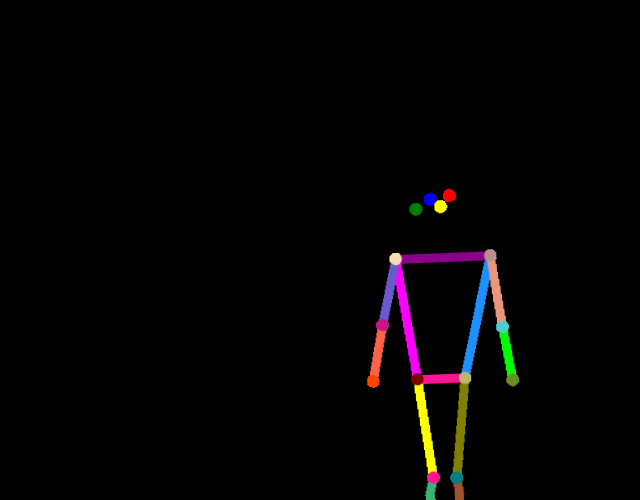

file: training_data/augmented_imgs/normal_814997.png


In [10]:
import IPython.display as display
import matplotlib.pyplot as plt

# lets check samples of our images to see what they look like
for n in range(3):  
    image = random.choice(all_image_paths)
    display.display(display.Image(str(image)))
    print(f"file: {image}")

In [11]:
# get unique classes
huia_person=[]
for label in all_image_labels:
    if label not in huia_person:
        huia_person.append(label)
huia_person = sorted(huia_person) # sort label list
huia_person

['backpack',
 'dramatic',
 'fly',
 'hadouken',
 'moonwalk',
 'normal',
 'underarm',
 'wings']

In [12]:
# put them in a dict for lookup
label_to_index = dict((name, index) for index,name in enumerate(huia_person))
label_to_index

{'backpack': 0,
 'dramatic': 1,
 'fly': 2,
 'hadouken': 3,
 'moonwalk': 4,
 'normal': 5,
 'underarm': 6,
 'wings': 7}

In [13]:
# lets format it, so we can copy and paste the dict direclty into javascript :-)
print("POSE_CLASSES = {")
for index,name in enumerate(huia_person):
    print("\t" +str(index)+": '"+name+"',")
print("}")

POSE_CLASSES = {
	0: 'backpack',
	1: 'dramatic',
	2: 'fly',
	3: 'hadouken',
	4: 'moonwalk',
	5: 'normal',
	6: 'underarm',
	7: 'wings',
}


(500, 640, 3)
<dtype: 'uint8'>


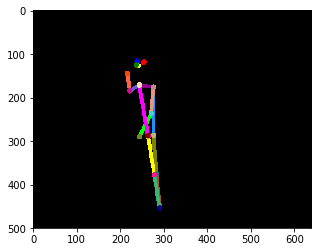

In [14]:
# load data into tf data
img_raw = tf.io.read_file(all_image_paths[0])
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
plt.imshow(img_tensor)

#img_raw.numpy()




In [15]:
import numpy
from random import randint
import math

def  preprocess_image(image):
    #print("EagerMode:" + str(tf.executing_eagerly()))
    # decode PNG
    image = tf.image.decode_png(image, channels=3)    
    
    # data augmentation - doing statically via fastai, as tensorflow addons is not compatible with graph mode yet 
    # rotate random
    degrees = random.randint(-6,6)
    angle = degrees * math.pi / 180
    #image = tfa.image.rotate(image,angle,interpolation='BILINEAR')
    
    # random crop - images are tensors of shape (500,640,3)
    crop_factor = (random.randint(0,20)/100) # generate numbers between 0.7 and 1.0
    new_width = int(640 * (1-crop_factor))
    new_height = int(500 * (1-crop_factor))
    # resize_image_with_crop_or_pad
    # image = tf.image.resize_image_with_crop_or_pad(image,new_height,new_width)
    
    # resize
    image = tf.image.resize(image, [224, 224])

    # normalize = convert to [-1:1]    
    offset = 127.5
    image = (image-offset)/offset
    return image

def load_and_preprocess_image(path):    
    image = tf.io.read_file(path)
    return preprocess_image(image)


W0518 10:45:28.218163 140596032284480 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


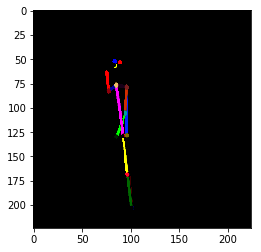

In [16]:
# load data into tf data
img_tensor = load_and_preprocess_image(all_image_paths[0])
plt.imshow(img_tensor)

In [17]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

next(iter(path_ds))

<tf.Tensor: id=43, shape=(), dtype=string, numpy=b'training_data/augmented_imgs/moonwalk_86998.png'>

In [18]:
# force non performatic eager mode as tfa.image doesn't support graph mode yet
#image_ds = path_ds.map(lambda path: tf.py_function(func=load_and_preprocess_image,inp=[path],Tout=tf.float32))
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls = AUTOTUNE)

In [19]:
all_image_labels_idx = [label_to_index[label] for label in all_image_labels]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_idx, tf.int64))
len(all_image_labels)

4191

In [20]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds
image_count = len(all_image_labels)

type(image_label_ds)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [21]:
ds = image_label_ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [22]:
# we will use a pretrained mobilenet for transferlearning
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
image_batch, label_batch = next(iter(ds))
print(image_batch.shape)

(64, 224, 224, 3)


In [24]:
label_batch[0].numpy()
image_batch[0].numpy()

array([[[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       ...,

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]]

In [25]:
image_batch, label_batch = next(iter(ds))

feature_map_batch = mobilenet(image_batch)
print(feature_map_batch.shape)

(64, 7, 7, 1280)


In [26]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu',bias_initializer=tf.keras.initializers.he_normal(),name='features'),
    tf.keras.layers.Dense(len(huia_person),activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [27]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.051436294
max logit: 0.29406202

Shape: (64, 8)


In [28]:
len(model.trainable_variables) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [29]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

66.0

In [30]:
import OneCycleLR
from datetime import datetime
now = datetime.now()
log_dir = "./logs/1_" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = []

# logging
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
tbCallback.set_model(model)
callbacks.append(tbCallback)

epochs = 20
max_lr = 3e-4

# One Cycle https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

cyclical_momentum = False
augment = True
cycles = 2.35

iterations = round(len(all_image_paths)/BATCH_SIZE*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

clr = OneCycleLR.CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

callbacks.append(clr)

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy')>0.9):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True

# earlyStopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss')
# callbacks.append(earlyStopping)

# chkPoint = tf.keras.callbacks.ModelCheckpoint('./models.h5')
# chkPoint.set_model(model)
# callbacks.append(chkPoint)

In [31]:
#ds.shuffle(buffer_size=32)
# skip 20% validation images
test_dataset = ds.take(838) 
train_dataset = ds.skip(838)

In [32]:
mobilenet.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.fit(train_dataset, epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/20
66/66 [==============================] - 27s 411ms/step - loss: 1.7863 - accuracy: 0.3800 - val_loss: 1.7249 - val_accuracy: 0.3722
Epoch 2/20
66/66 [==============================] - 11s 166ms/step - loss: 0.7566 - accuracy: 0.8011 - val_loss: 1.2242 - val_accuracy: 0.5237
Epoch 3/20
66/66 [==============================] - 11s 172ms/step - loss: 0.2737 - accuracy: 0.9169 - val_loss: 1.1410 - val_accuracy: 0.5597
Epoch 4/20
66/66 [==============================] - 11s 168ms/step - loss: 0.1479 - accuracy: 0.9519 - val_loss: 1.1319 - val_accuracy: 0.6080
Epoch 5/20
66/66 [==============================] - 11s 170ms/step - loss: 0.1288 - accuracy: 0.9588 - val_loss: 2.1048 - val_accuracy: 0.3639
Epoch 6/20
66/66 [==============================] - 11s 170ms/step - loss: 0.0941 - accuracy: 0.9659 - val_loss: 0.9381 - val_accuracy: 0.6605
Epoch 7/20
66/66 [==============================] - 11s 167ms/step - loss: 0.0670 - accuracy: 0.9777 - val_loss: 1.7007 - val_accuracy: 0.5142

In [34]:
from datetime import datetime
now = datetime.now()
log_dir = "./logs/2_" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = []

epochs = 50
max_lr = 3e-6

# One Cycle https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

cyclical_momentum = False
augment = True
cycles = 2.35

iterations = round(len(all_image_paths)/BATCH_SIZE*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

clr = OneCycleLR.CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

callbacks.append(clr)

# logging
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
tbCallback.set_model(model)
callbacks.append(tbCallback)

In [35]:
mobilenet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/50
66/66 [==============================] - 67s 1s/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.5123 - val_accuracy: 0.8348
Epoch 2/50
66/66 [==============================] - 29s 442ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.4603 - val_accuracy: 0.8487
Epoch 3/50
66/66 [==============================] - 29s 438ms/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.4211 - val_accuracy: 0.8591
Epoch 4/50
66/66 [==============================] - 29s 440ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.4033 - val_accuracy: 0.8608
Epoch 5/50
66/66 [==============================] - 63s 956ms/step - loss: 0.0076 - accuracy: 0.9986 - val_loss: 0.3761 - val_accuracy: 0.8686
Epoch 6/50
65/66 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978

In [ ]:
model.save("models/huia_mob_224_final_lifecycle.h5") # 1.0

In [ ]:
model

# Convert to TENSORFLOW JS

In [ ]:
import tensorflowjs as tfjs
import numpy as np

tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_final_q16_2",quantization_dtype=np.uint16)
tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_final_q8_2",quantization_dtype=np.uint8)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_layer_names=False) #,show_shapes=True)

# Tensorboard Visualization

In [ ]:
# https://www.tensorflow.org/tensorboard/
import tensorboard as tb
%load_ext tensorboard.notebook

#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000)
#!kill 25264

In [ ]:
%tensorboard --logdir ./logs

In [ ]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

In [ ]:
timeit(ds)

# Predict

In [ ]:
import numpy as np
sample = np.reshape(img_final,[1,224,224,3])

predict = int(model.predict_classes(sample))
predict

In [ ]:
[key for key,value in label_to_index.items() if value == predict]

In [ ]:
label_to_index

# UTILS

## Delete Images that are empty

In [ ]:
# during image capture some images are empty, so we automatically delete them

# open images and delete if they are empty
def remove_empty_imgs(imgpath):
    for item in imgpath.iterdir():
        im = imread(str(item), format='png')
        if np.count_nonzero(im)==0: 
            print(item,np.count_nonzero(im))
            os.remove(str(item))
            
remove_empty_imgs(image_path)

## Sync JSONs with Images

In [ ]:
# since we might delete unwanted images for training, this will also delete the json files
# sync json & images 

def sync_json_images(json_paths, img_path):
    for json in json_paths:
        #print(json.stem, end=" ")
        img = img_path/f"{json.stem}.png"
        if not Path(img).exists():
            print(f"{img} doesn't exist, deleting {json}")
            Path(json).unlink()
        
sync_json_images(all_json_paths, image_path)

# Static Data Augmentation
Decided to use FASTAI to statically preprocess data augmentation, as tensorflow addons (0.3.1) still didn't support graph mode and is therefore not compatible with tf.data.Dataset mappings




In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from random import randint
import pathlib

root_path = pathlib.Path("./training_data/")
save_fast = Path('./training_data/augmented_imgs/')
save_fast.mkdir(parents=True, exist_ok=True)

tfms = get_transforms(do_flip=False, 
                            flip_vert=False, 
                            max_rotate=6, 
                            max_zoom=1.2, 
                            max_lighting=None, 
                            max_warp=0.2, 
                            p_affine=0.2, 
                            p_lighting=0)


image_path = root_path /"images"
all_image_paths = list(image_path.glob('*.png'))


def generate_augmented(qty):
    for f in all_image_paths:
        image = open_image(f)
        for i in range(0,qty):
            image_fast = image.apply_tfms(tfms[0])
            save_name = str(save_fast) + '/' + f.stem + '99' + str(i) + f.suffix
            print(save_name)
            image_fast.save(save_name)

# generate 20 variations of each image
generate_augmented(10)